In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import fftpack
from scipy import signal

In [312]:
sampling_rate = 4000
gain = 12
v_ref = 4.5
resolution = (2**23) - 1

In [313]:
channel_offset = np.load('data/channel_data_differential.npy')
df = pd.DataFrame(data=channel_offset.T).set_index(0)
df = (df * v_ref) / resolution
df /= gain
df.columns = "channel_" + df.columns.astype(str)
df.index.name = "timestamp"
df.index -= min(df.index)
df.index /= 10**6
df = df - df.mean(axis=0)

In [314]:
# Find FFT
N = len(df)
T = 1 / sampling_rate
x = np.linspace(0.0, 1.0/(2.0*T), N//2)
df_fft = df.apply(scipy.fftpack.fft, axis=0, raw=True)

In [315]:
# Bandpass filter
high = 20        # Remove DC-related noise
low = 400       # EMG harmonics above 400Hz are generally due to noise
b, a = scipy.signal.butter(4, [high,low], btype='bandpass', fs=sampling_rate)
butter_filter = lambda x: scipy.signal.filtfilt(b, a, x)
df_butter = df.apply(butter_filter, axis=0, raw=True)


N_butter = len(df_butter)
x_butter = np.linspace(0.0, 1.0/(2.0*T), N_butter//2)
df_butter_fft = df.apply(scipy.fftpack.fft, axis=0, raw=True)


In [316]:
# Comb filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 10.0
b_notch, a_notch = scipy.signal.iircomb(w0=notch_freq, Q=quality_factor, fs=sampling_rate, ftype='notch')
freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
comb_filter = lambda x: scipy.signal.filtfilt(b_notch, a_notch, x)
df_comb = df_butter.apply(comb_filter, axis=0, raw=True)

N_comb = len(df_comb.index)
x_comb = np.linspace(0.0, 1.0/(2.0*T), N_comb//2)
df_comb_fft = df.apply(scipy.fftpack.fft, axis=0, raw=True)

In [317]:
# Find noise floor
noise_data = np.load('data/channel_noise_external.npy')
df_n = pd.DataFrame(data=noise_data.T).set_index(0)
df_n = (df_n * v_ref) / resolution
df_n /= gain
df_n.columns = "channel_" + df_n.columns.astype(str)
df_n.index.name = "timestamp"
df_n.index -= min(df_n.index)
df_n.index /= 10**6

noise = df_n.channel_3
noise = noise.to_numpy()
noise = noise - noise.mean()

# Bandpass filter
high = 20        # Remove DC-related noise
low = 400       # EMG harmonics above 400Hz are generally due to noise
b, a = scipy.signal.butter(4, [high,low], btype='bandpass', fs=sampling_rate)
noise = scipy.signal.filtfilt(b, a, noise)

# Comb filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 5.0
b_notch, a_notch = scipy.signal.iircomb(w0=notch_freq, Q=quality_factor, fs=sampling_rate, ftype='notch')
freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
noise = scipy.signal.filtfilt(b_notch, a_notch, noise)

In [318]:
# Calculate SNR
power_s = 1/(len(y_notched)) * np.abs(y_notched)**2
power_n = 1/(len(noise)) * np.abs(noise)**2
l = min(len(y_notched), len(noise))
power_s = power_s[:l]
power_n = power_n[:l]
snr = 10*np.log10((np.abs(power_s - power_n))/power_n)      # SNR in dB
snr.mean()

26.342485311698297

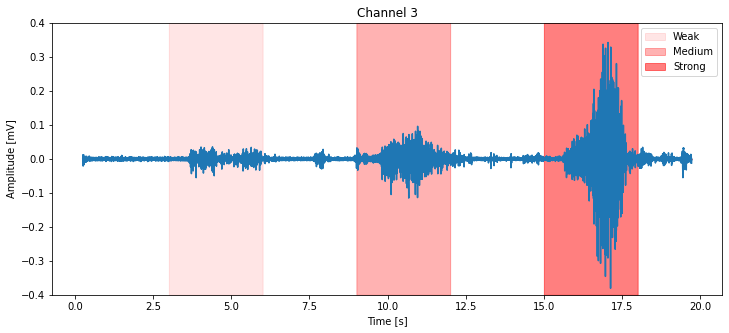

In [357]:
# Plot single channel
d = df_comb.iloc[1000:-1000]
fig = plt.figure(figsize=(12,5))
plt.plot(d.channel_3*1000)
plt.ylim(-0.4, 0.4)
plt.title('Channel 3')
plt.ylabel('Amplitude [mV]')
plt.xlabel('Time [s]')

timestamps = d.index.to_numpy()
flex1 = np.zeros_like(timestamps)
flex2 = np.zeros_like(timestamps)
flex3 = np.zeros_like(timestamps)
flex1[(timestamps > 3) & (timestamps <6)] = 1.0
flex2[(timestamps > 9) & (timestamps <12)] = 1.0
flex3[(timestamps > 15) & (timestamps <18)] = 1.0

plt.fill_between(timestamps, flex1*0.4, -flex1*0.4, color="red", alpha=0.1, label="Weak")
plt.fill_between(timestamps, flex2*0.4, -flex2*0.4, color="red", alpha=0.3, label="Medium")
plt.fill_between(timestamps, flex3*0.4, -flex3*0.4, color="red", alpha=0.5, label="Strong")
plt.legend()


In [258]:
df_comb

,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8
timestamp,,,,,,,,
0.000000,-0.003058,-0.002820,-0.002550,-0.001911,-0.003066,-0.001969,-0.004412,-0.004538
0.000084,-0.003189,-0.002692,-0.002031,-0.000403,-0.003113,-0.000377,-0.005327,-0.005494
0.000335,-0.003581,-0.002849,-0.001846,0.000620,-0.003439,0.000724,-0.006516,-0.006739
0.000583,-0.004742,-0.003791,-0.002503,0.000610,-0.004560,0.000783,-0.008604,-0.008919
0.000832,-0.006948,-0.005795,-0.004284,-0.000745,-0.006759,-0.000508,-0.011889,-0.012337
...,...,...,...,...,...,...,...,...
19.951867,0.009762,0.009859,0.009921,0.009754,0.009688,0.009872,0.009704,0.009767
19.952117,0.008126,0.008259,0.008314,0.007808,0.008003,0.008198,0.007720,0.007733
19.952367,0.006817,0.006938,0.006969,0.006250,0.006684,0.006813,0.006362,0.006356


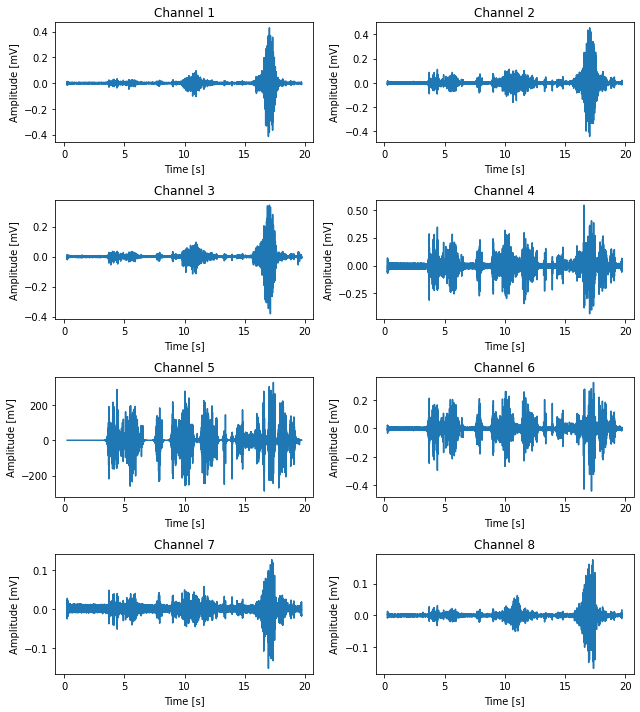

In [320]:
# Plot channels
plt.figure(figsize=(9,10))
for i, c in enumerate(df_comb.columns):
    plt.subplot(4, 2, i+1)
    df_comb[c].iloc[1000:-1000].multiply(1000).plot()
    plt.title('Channel ' + str(i+1))
    plt.ylabel('Amplitude [mV]')
    plt.xlabel('Time [s]')
plt.tight_layout()

Text(0, 0.5, 'Arbitrary unit')

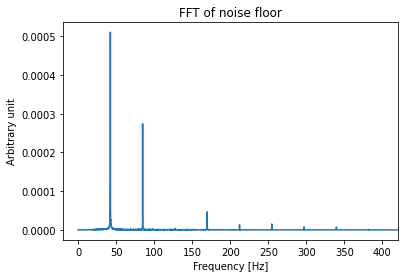

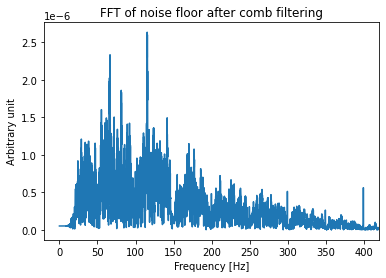

In [321]:
# FFT Plots

fig = plt.figure()
plt.plot(x_butter, 2.0/N_butter * np.abs(y_butter_fft[:N_butter//2]))
plt.xlim(-20, 420)
# plt.ylim(-1e-7, 9e-6)
plt.title('FFT of noise floor')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')

fig = plt.figure()
plt.plot(x_notched, 2.0/N_notched * np.abs(y_notched_fft[:N_notched//2]))
plt.xlim(-20, 420)
# plt.ylim(-1e-7, 9e-6)
plt.title('FFT of noise floor after comb filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Arbitrary unit')